# Compute the magnitudes

- author Sylvie Dagoret-Campagne
- creation date July 13


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os,sys
import matplotlib.pyplot as plt
from astropy.io import fits

%matplotlib inline
from IPython.display import Image, display
from scipy.interpolate import interp1d

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [4]:
PATH_LIBRADTRAN='./libradtran'

In [5]:
sys.path.append(PATH_LIBRADTRAN)

In [6]:
import libsimulateTranspLSSTScattAbsAer3 as rt

In [7]:
from lsst.sims.photUtils import SignalToNoise
from lsst.sims.photUtils import PhotometricParameters
from lsst.sims.photUtils import Bandpass,Sed

In [8]:
from MyTelescope import *
from MyThroughputs import *

# LSST

In [9]:
all_filternum = {'u':1, 'g':2, 'r':3, 'i':4, 'z':5, 'y':6}
all_filtercolors = {'u':'b', 'g':'g', 'r':'r', 'i':'y', 'z':'grey', 'y':'k'}
all_filtername= ['u','g','r','i','z','y']
all_filtercmap=["Blues","Greens","Reds","Oranges","Greys","Purples"]

In [10]:
LSST_SkyBrightness=np.array([22.03,21.68,21.02,19.7,17.83,17.21])

In [11]:
LSST_GeomSeeing=np.array([1.1,1.02,0.95,0.92,0.88,0.94])

## Read SED

In [12]:
input_fits='regenerated_sedgrid_pickle_uvk.fits'

In [13]:
hdul = fits.open(input_fits)

In [14]:
hdul.info()

Filename: regenerated_sedgrid_pickle_uvk.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      17   (8515, 12963)   float64   


In [15]:
hdr=hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 8515                                                  
NAXIS2  =                12963                                                  
NBSED   =                12962                                                  
NBWLBIN =                 8510                                                  
WLMIN   =               3000.0                                                  
WLMAX   =              11510.0                                                  
WLBINWDT=                  1.0                                                  
SEDUNIT = 'FLAM    '                                                            
SEDMODEL= 'pickle_uvk'                                                          
IDX_NUM =                   

In [16]:
index_num=hdr["IDX_NUM"]
index_val=hdr["IDX_VAL"]
#index_temp=hdr["IDX_TEMP"]
#index_logg=hdr["IDX_LOGG"]
#index_logz=hdr["IDX_LOGZ"]
index_spec=hdr["IDX_SPEC"]
#index_mag=hdr["IDX_MAG"]

In [17]:
MAGMIN=[15,15,15,15,15,15]
MAGMAX=[25,25,25,25,25,55]
COLORMIN=[-0.5,-0.5,-0.5,-1.5,-2.0]
COLORMAX=[4.,2.0,2.5,2.0,2.0]

In [18]:
def plot_sedimg(data):
    plt.figure(figsize=(15,10))   
    img=plt.imshow(data[1:,index_spec:],origin='lower',cmap='jet')
    plt.colorbar(img)
    plt.grid(True)
    plt.title('sed grid')
    plt.xlabel('bin number of wavelengths')
    plt.ylabel('sed number')
    plt.show()

In [19]:
def plot_allsed(data):
    plt.figure()   
    
    for idx in np.arange(data.shape[0]-1):
        if data[1+idx,index_val]>0:
            plt.semilogy(data[0,index_spec:],data[1+idx,index_spec:],'-')
    plt.semilogy(data[0,index_spec:],sed_data[2113+1,index_spec:],'k-',lw=3)
    plt.grid(True)
    plt.title('Regenerated SED')
    plt.xlabel('wavelength (A)')
    plt.ylabel('sed (flam: erg/cm2/s/A)')
    plt.show()

In [20]:
sed_data = hdul[0].data

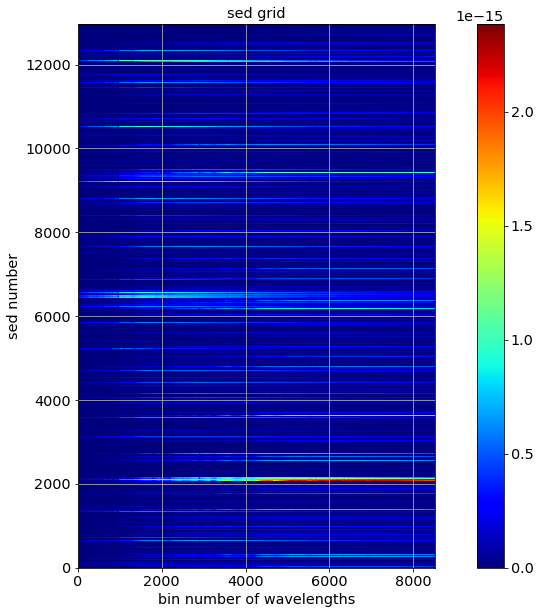

In [21]:
plot_sedimg(sed_data)

In [22]:
#plot_allsed(sed_data)

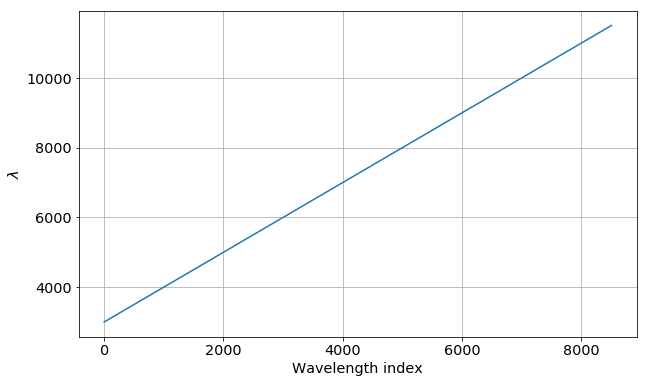

In [23]:
plt.plot(sed_data[0,index_spec:])
plt.grid()
plt.ylabel("$\lambda$")
plt.xlabel("Wavelength index")

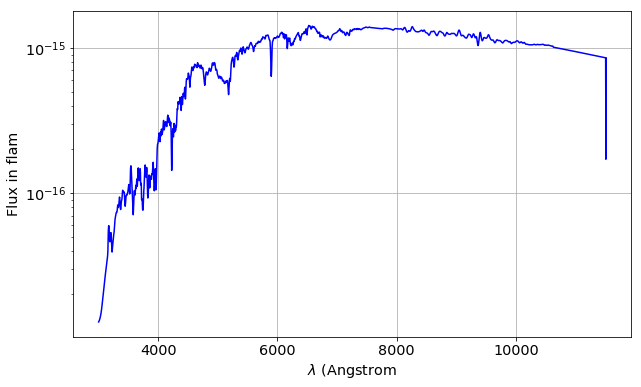

In [24]:
plt.semilogy(sed_data[0,index_spec:],sed_data[2113+1,index_spec:],'b-')
plt.grid()
plt.xlabel("$\lambda$ (Angstrom")
plt.ylabel("Flux in flam")

In [25]:
NBSED=sed_data.shape[0]-1

In [26]:
NBSED_SEL=NBSED

# Simulate atmosphere

In [27]:
am=1.2
pressure = 782.5
pwv=4
aer=0
ozone=350.
wl0=500.

In [28]:
path,thefile=rt.ProcessSimulationaer(am,pwv,ozone,wl0,aer)
#path,thefile=ProcessSimulation(am,pwv,ozone)
rtdata = np.loadtxt(os.path.join(path,thefile))
wl=rtdata[:,0]
tr=rtdata[:,1]

--------------------------------------------
 1) airmass =  1.2
 2) pwv =  4
 3) oz =  350.0
 4) wl0 =  500.0
 5) tau0 =  0
--------------------------------------------
Running uvspec with input file:  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv40_oz35_aer0.INP
Output to file                :  /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv40_oz35_aer0.OUT
uvspec cmd:  /pbs/throng/lsst/users/dagoret/External/libRadtran/libRadtran-2.0.1/bin/uvspec  < /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/in/RT_LS_pp_us_sa_rt_z12_wv40_oz35_aer0.INP > /scratch/dagoret/simulations/RT/2.0.1/LS/pp/us/sa/rt/out/RT_LS_pp_us_sa_rt_z12_wv40_oz35_aer0.OUT


In [29]:

#libradtranpath = os.getenv('LIBRADTRANDIR')

In [31]:
tel=Telescope()

**** Throughputs.__init__****
System loaded from /sps/lsst/software/lsst_sims/sims_2_7_0/stack/miniconda3-4.3.21-10a4fa6/Linux64/throughputs/2017.01.31-6-g29ce4f5/baseline/
**** Telescope.__init__******


In [32]:
tel.Set_Atmosphere(am,wl,tr)

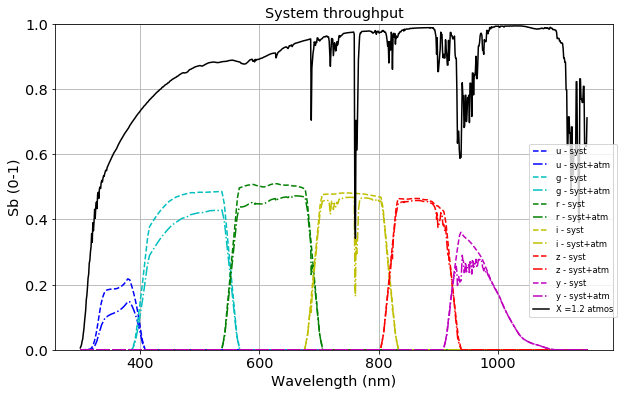

In [33]:
tel.Plot_Throughputs()

# Simulate One SED only

In [34]:
wavelength=sed_data[0,index_spec:]/10.
S_wl_flux=sed_data[2113+1,index_spec:]*10
starname='pickle_uvk_{}'.format(2113)

In [35]:
tel.Set_SED(wavel=wavelength,newsed=S_wl_flux,name=starname)

In [36]:
# loop on filters
for key, value in all_filternum.items():
        
    filt_str=key
    filt_idx=value-1
            
    mag_ab0=tel.CalcMyABMagnitude_filter(filt_str)
    mag_err=tel.CalcMyABMagnitudesError_filter(filt_str,LSST_SkyBrightness[filt_idx],LSST_GeomSeeing[filt_idx])
    
    print("{} , mag_AB= {:4.2f} , mag_err= {:5.3f}".format(filt_str,mag_ab0,mag_err))

u , mag_AB= 19.59 , mag_err= 0.015
g , mag_AB= 17.13 , mag_err= 0.005
r , mag_AB= 15.94 , mag_err= 0.005
i , mag_AB= 15.39 , mag_err= 0.005
z , mag_AB= 15.14 , mag_err= 0.008
y , mag_AB= 15.02 , mag_err= 0.008


# Simulate magnitudes and their errors in all filters  for all SED

In [37]:
NBSED

12962

In [38]:
NBSED_SEL

12962

In [39]:
NBFILTERS=len(all_filternum)

In [40]:
for key, value in all_filternum.items():
    print("{}, {}".format(key,value))

u, 1
g, 2
r, 3
i, 4
z, 5
y, 6


In [41]:
# conf
wavelength=sed_data[0,index_spec:]/10.
MagnitudesAB0=np.zeros((NBSED_SEL,NBFILTERS))
MagnitudesAB0_err=np.zeros((NBSED_SEL,NBFILTERS))
MagnitudesAB_rand=np.zeros((NBSED_SEL,NBFILTERS))

# loop on SED
for idx_sed in np.arange(NBSED_SEL):
    
    S_wl_flux=sed_data[idx_sed+1,index_spec:]*10
    starname='pickle_uvk_{}'.format(idx_sed)
    
    #thesed=Sed(wavelen=wavelength,flambda=S_wl_flux,fnu=0,name=starname)
    #thesed.flambdaTofnu()
    
    tel.Set_SED(wavel=wavelength,newsed=S_wl_flux,name=starname)
    
    # loop on filters
    for key, value in all_filternum.items():
        
        filt_str=key
        filt_idx=value-1
        
       
        
        mag_ab0=tel.CalcMyABMagnitude_filter(filt_str)
        mag_err=tel.CalcMyABMagnitudesError_filter(filt_str,LSST_SkyBrightness[filt_idx],LSST_GeomSeeing[filt_idx])
        
        fl_0=np.power(10,-0.4*mag_ab0)
        sigma_fl=2.3/2.5*mag_err*fl_0
        
        fl_rand = np.random.normal(fl_0, sigma_fl,1)[0]
        
        while fl_rand<0:
            fl_rand = np.random.normal(fl_0, sigma_fl,1)[0]
            
        mag_rand=-2.5*np.log10(fl_rand)
        
        MagnitudesAB0[idx_sed,filt_idx]=mag_ab0
        MagnitudesAB0_err[idx_sed,filt_idx]=mag_err
        MagnitudesAB_rand[idx_sed,filt_idx]=mag_rand
        
        

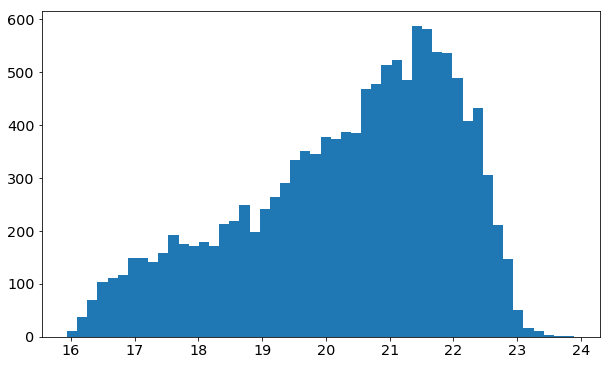

In [42]:
plt.hist(MagnitudesAB0[:,2],bins=50);

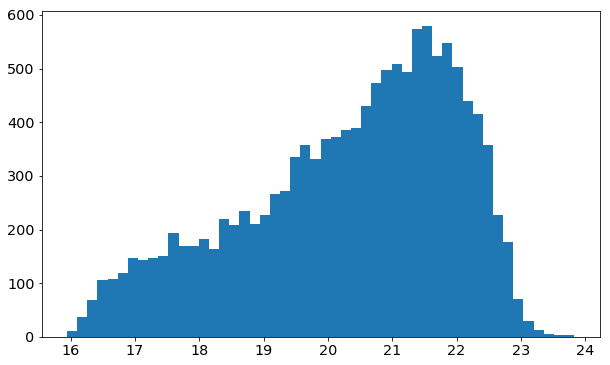

In [43]:
plt.hist(MagnitudesAB_rand[:,2],bins=50);

In [44]:
def PlotMagnitudesForFilters(allarray,nbins=50,theglobaltitle='title',thextitle='thextitle'):
    
    f, axarr = plt.subplots(2, 3,figsize=(18,10))
    
    for key, value in all_filternum.items():
        
        filt_str=key
        filt_idx=value-1
        
        idy=int(filt_idx/3)
        idx=int(filt_idx-idy*3)
     
        array=allarray[:,filt_idx]
        mean=array.mean()
        sigma=array.std()
        c=len(array)
        
        stat=": m={:3.1f} , $\sigma$= {:3.2f} , c={}".format(mean,sigma,c)
    
        thetitle='filt {}'.format(filt_str)+stat
    
        axarr[idy, idx].hist(array,bins=nbins,color=all_filtercolors[filt_str])
        axarr[idy, idx].set_title(thetitle,fontweight='bold')
        axarr[idy, idx].set_xlabel(thextitle,fontweight='bold')
        axarr[idy, idx].grid(True)
    
      
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.3   # the amount of width reserved for blank space between subplots
    hspace = 0.3   # the amount of height reserved for white space between subplots
    f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=wspace)
    
    f.suptitle(theglobaltitle,fontsize=20,fontweight='bold')

In [45]:
def PlotColorsForFilters(allarray,theglobaltitle='title'):
    
    f, axarr = plt.subplots(2, 2,figsize=(12,11))
    
    for key, value in all_filternum.items():
        
        filt_str=key
        filt_idx=value-1
        
        if filt_idx<5 and filt_idx>=1:
        
            idy=int((filt_idx-1)/2)
            idx=int((filt_idx-1)-idy*2)
     
            magarray1=allarray[:,filt_idx-1]
            magarray2=allarray[:,filt_idx]
            magarray3=allarray[:,filt_idx+1]
            
            c1=magarray1-magarray2
            c2=magarray2-magarray3
            
            thextitle="{} - {} ".format(all_filtername[filt_idx-1],all_filtername[filt_idx])
            theytitle="{} - {} ".format(all_filtername[filt_idx],all_filtername[filt_idx+1])  
        
       
    
            axarr[idy, idx].scatter(c1,c2,marker='.',color=all_filtercolors[filt_str])
            #axarr[idy, idx].set_title(thetitle,fontweight='bold')
            axarr[idy, idx].set_xlabel(thextitle,fontweight='bold')
            axarr[idy, idx].set_ylabel(theytitle,fontweight='bold')
            axarr[idy, idx].set_xlim(COLORMIN[filt_idx-1],COLORMAX[filt_idx-1])
            axarr[idy, idx].set_ylim(COLORMIN[filt_idx],COLORMAX[filt_idx])
            axarr[idy, idx].grid(True)
    
      
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.3   # the amount of width reserved for blank space between subplots
    hspace = 0.3   # the amount of height reserved for white space between subplots
    f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=wspace)
    
    f.suptitle(theglobaltitle,fontsize=20,fontweight='bold')

In [46]:
def PlotColorsContoursForFilters(allarray,theglobaltitle='title'):
    
    f, axarr = plt.subplots(2, 2,figsize=(12,11))
    
    for key, value in all_filternum.items():
        
        filt_str=key
        filt_idx=value-1
        
        if filt_idx<5 and filt_idx>=1:
        
            idy=int((filt_idx-1)/2)
            idx=int((filt_idx-1)-idy*2)
     
            magarray1=allarray[:,filt_idx-1]
            magarray2=allarray[:,filt_idx]
            magarray3=allarray[:,filt_idx+1]
            
            c1=magarray1-magarray2
            c2=magarray2-magarray3
            
            thextitle="{} - {} ".format(all_filtername[filt_idx-1],all_filtername[filt_idx])
            theytitle="{} - {} ".format(all_filtername[filt_idx],all_filtername[filt_idx+1])  
        
            xedges=np.linspace(COLORMIN[filt_idx-1],COLORMAX[filt_idx-1],51)
            yedges=np.linspace(COLORMIN[filt_idx],COLORMAX[filt_idx],51)
    
            X=c1
            Y=c2
            H, xedges, yedges = np.histogram2d(X, Y, bins=(xedges, yedges))
            H = H.T  # Let each row list bins with common y range.
            Xgr, Ygr = np.meshgrid(xedges[:-1], yedges[:-1])
            
            
            cs=axarr[idy,idx].contourf(Xgr,Ygr,H,50,vmin=H.min(),vmax=H.max(),cmap=all_filtercmap[filt_idx])
    
            #axarr[idy, idx].scatter(c1,c2,marker='.',color=all_filtercolors[filt_str])
            #axarr[idy, idx].set_title(thetitle,fontweight='bold')
            axarr[idy, idx].set_xlabel(thextitle,fontweight='bold')
            axarr[idy, idx].set_ylabel(theytitle,fontweight='bold')
            #axarr[idy, idx].set_xlim(COLORMIN[filt_idx-1],COLORMAX[filt_idx-1])
            #axarr[idy, idx].set_ylim(COLORMIN[filt_idx],COLORMAX[filt_idx])
            axarr[idy, idx].grid(True)
    
      
    left  = 0.125  # the left side of the subplots of the figure
    right = 0.9    # the right side of the subplots of the figure
    bottom = 0.1   # the bottom of the subplots of the figure
    top = 0.9      # the top of the subplots of the figure
    wspace = 0.3   # the amount of width reserved for blank space between subplots
    hspace = 0.3   # the amount of height reserved for white space between subplots
    f.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=wspace)
    
    f.suptitle(theglobaltitle,fontsize=20,fontweight='bold')

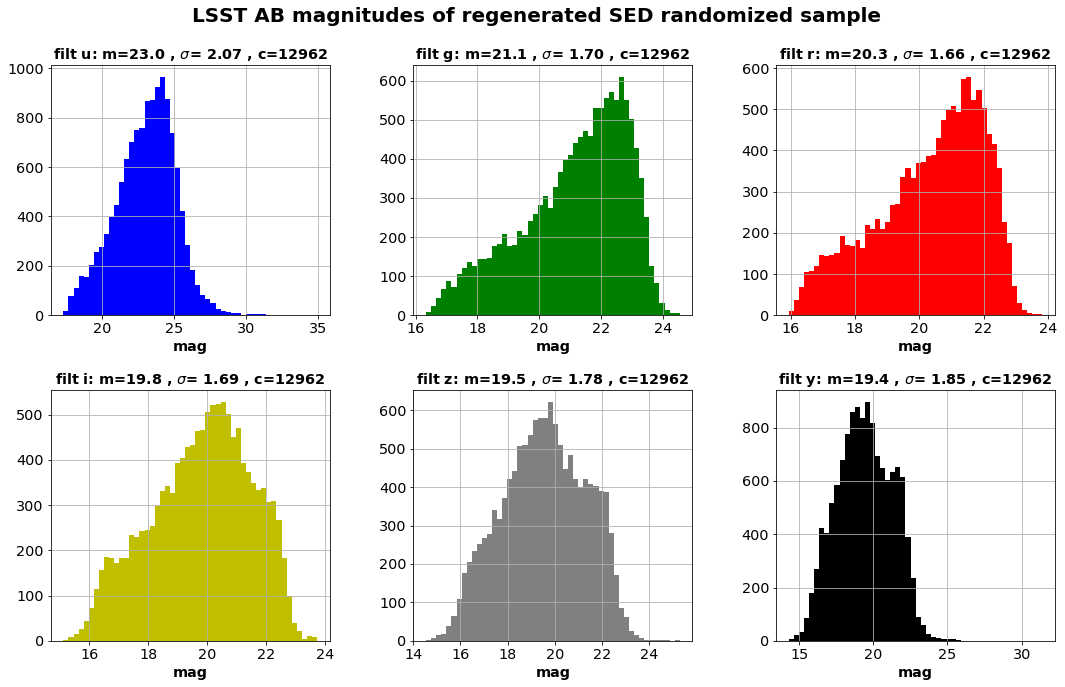

In [47]:
PlotMagnitudesForFilters(MagnitudesAB_rand,nbins=50,theglobaltitle='LSST AB magnitudes of regenerated SED randomized sample',thextitle='mag')

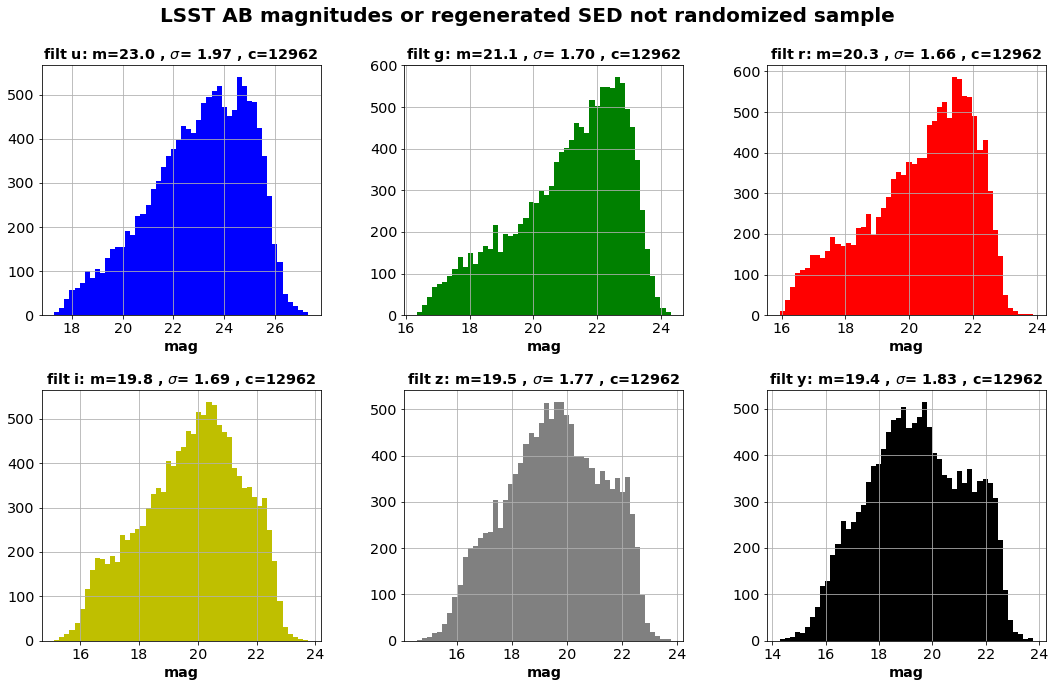

In [48]:
PlotMagnitudesForFilters(MagnitudesAB0,nbins=50,theglobaltitle='LSST AB magnitudes or regenerated SED not randomized sample',thextitle='mag')

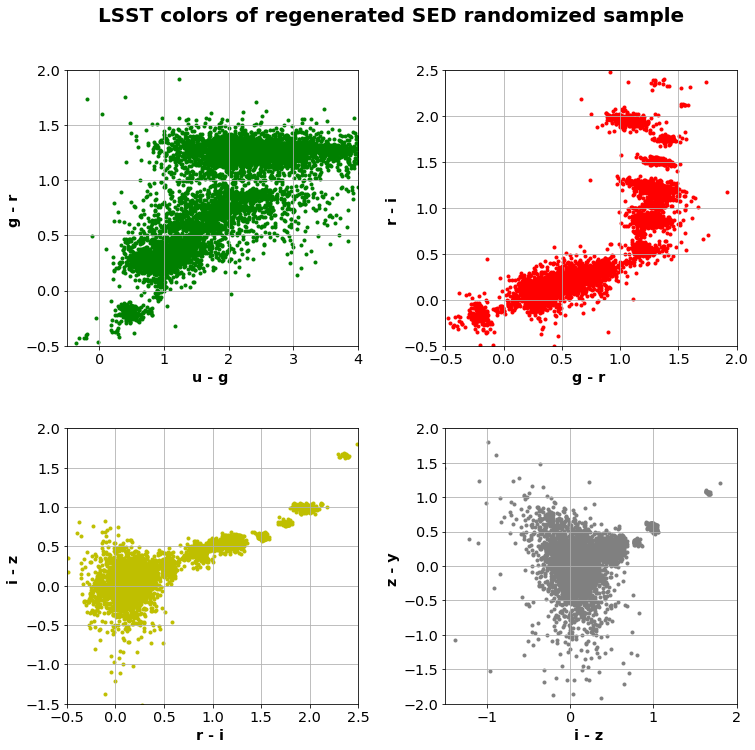

In [49]:
PlotColorsForFilters(MagnitudesAB_rand,theglobaltitle='LSST colors of regenerated SED randomized sample')

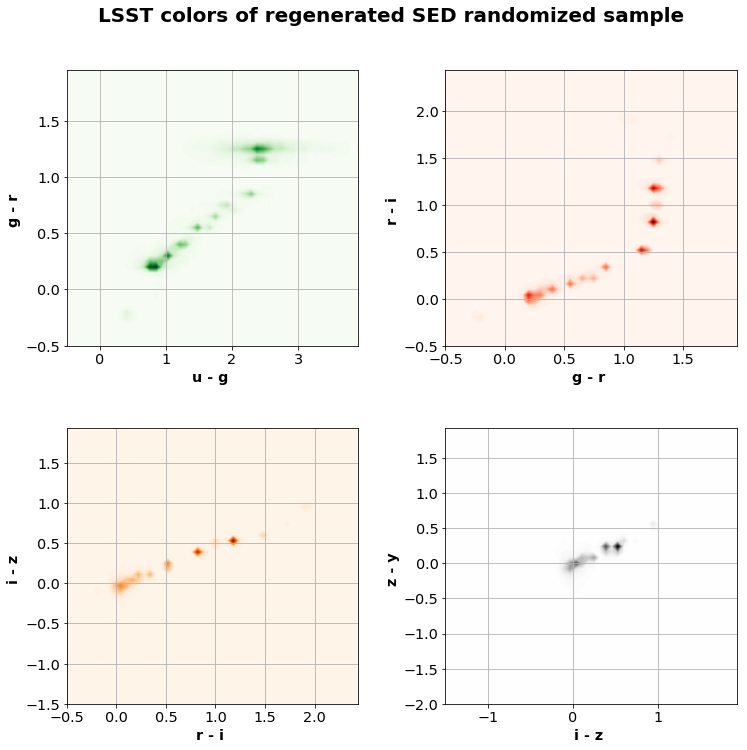

In [50]:
PlotColorsContoursForFilters(MagnitudesAB_rand,theglobaltitle='LSST colors of regenerated SED randomized sample')

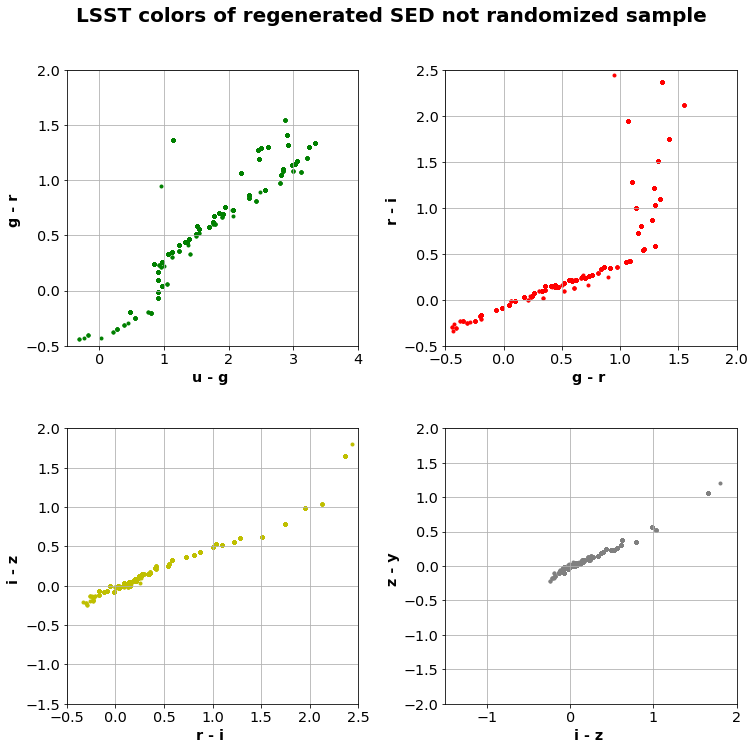

In [51]:
PlotColorsForFilters(MagnitudesAB0,theglobaltitle='LSST colors of regenerated SED not randomized sample')

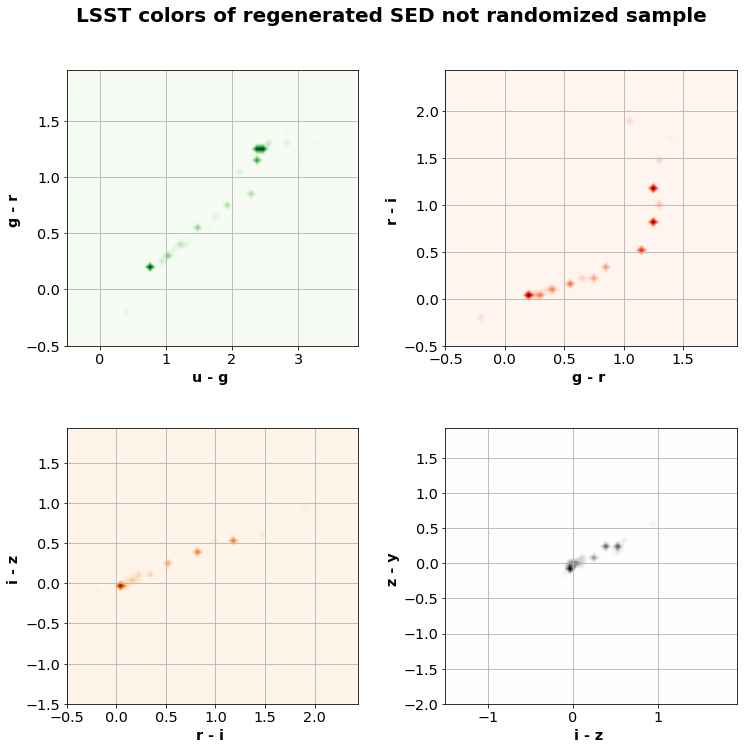

In [52]:
PlotColorsContoursForFilters(MagnitudesAB0,theglobaltitle='LSST colors of regenerated SED not randomized sample')